#### Script for finding undiagnozed lines in Kilonova Spectrum

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import math
from pcygni_profile import PcygniCalculator
from scipy.interpolate import interp1d
import astropy.units as units
import astropy.constants as csts

pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
def forbidden(ax): 
    top = 10
    #define telluric region
    ax.fill_between([13100, 14400], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.6 )
    ax.fill_between([17550, 19200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.6 )

    #poorly constrained regions
    ax.fill_between([5330, 5740], [-5*10**(-16)*fac, -5*10**(-16)*fac] , [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3   )
    ax.fill_between([9940, 10200], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3  )

    #define absorbtion feature
    #ax.fill_between([7000, 9000], [-5*10**(-17), -5*10**(-17)], [3*10**(-16), 3*10**(-16)], color='grey', alpha=0.1  )
    ax.fill_between([3000, 4000], [-5*10**(-16)*fac, -5*10**(-16)*fac], [top*10**(-16)*fac, top*10**(-16)*fac], color='grey', alpha=0.3  )


In [2]:
def bin_spectrum(wl, flux, error, mask, binh, weight=False):

    """Bin low S/N 1D data from xshooter
    ----------
    flux : np.array containing 2D-image flux
        Flux in input image
    error : np.array containing 2D-image error
        Error in input image
    binh : int
        binning along x-axis
    Returns
    -------
    binned fits image
    """

    print("Binning image by a factor: "+str(binh))
    if binh == 1:
        return wl, flux, error, mask

    # Outsize
    size = flux.shape[0]
    outsize = int(np.round(size/binh))

    # Containers
    wl_out = np.zeros((outsize))
    res = np.zeros((outsize))
    reserr = np.zeros((outsize))
    resbp = np.zeros((outsize))

    for ii in np.arange(0, size - binh, binh):
        # Find psotions in new array
        h_slice = slice(ii, ii + binh)
        h_index = int((ii + binh)/binh) - 1
        # Construct weighted average and weighted std along binning axis
        res[h_index], reserr[h_index], resbp[h_index] = avg(flux[ii:ii + binh], error[ii:ii + binh], mask = mask[ii:ii + binh], axis=0, weight=weight)
        wl_out[h_index] = np.median(wl[ii:ii + binh], axis=0)

    return wl_out[1:-1], res[1:-1], reserr[1:-1], resbp[1:-1]


def avg(flux, error, mask=None, axis=2, weight=False, weight_map=None):

    """Calculate the weighted average with errors
    ----------
    flux : array-like
        Values to take average of
    error : array-like
        Errors associated with values, assumed to be standard deviations.
    mask : array-like
        Array of bools, where true means a masked value.
    axis : int, default 0
        axis argument passed to numpy
    Returns
    -------
    average, error : tuple
    Notes
    -----
    """
    try:
        if not mask:
            mask = np.zeros_like(flux).astype("bool")
    except:
        pass
        # print("All values are masked... Returning nan")
        # if np.sum(mask.astype("int")) == 0:
        #     return np.nan, np.nan, np.nan


    # Normalize to avoid numerical issues in flux-calibrated data
    norm = abs(np.median(flux[flux > 0]))
    if norm == np.nan or norm == np.inf or norm == 0:
        print("Nomalization factor in avg has got a bad value. It's "+str(norm)+" ... Replacing with 1")

    flux_func = flux.copy() / norm
    error_func = error.copy() / norm

    # Calculate average based on supplied weight map
    if weight_map is not None:

        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # https://physics.stackexchange.com/questions/15197/how-do-you-find-the-uncertainty-of-a-weighted-average?newreg=4e2b8a1d87f04c01a82940d234a07fc5
        average = np.sum(flux_func * weight_map, axis = axis) / np.sum(weight_map, axis = axis)
        variance = np.sum(error_func**2 * weight_map**2, axis = axis) / np.sum(weight_map, axis = axis)**2



    # Inverse variance weighted average
    elif weight:
        ma_flux_func = np.ma.array(flux_func, mask=mask)
        ma_error_func = np.ma.array(error_func, mask=mask)
        w = 1.0 / (ma_error_func ** 2.0)
        average = np.ma.sum(ma_flux_func * w, axis = axis) / np.ma.sum(w, axis = axis)
        variance = 1. / np.ma.sum(w, axis = axis)
        if not isinstance(average, float):
            # average[average.mask] = np.nan
            average = average.data
            # variance[variance.mask] = np.nan
            variance = variance.data

    # Normal average
    elif not weight:
        # Number of pixels in the mean
        n = np.sum(np.array(~mask).astype("int"), axis = axis)
        # Remove non-contributing pixels
        flux_func[mask] = 0
        error_func[mask] = 0
        # mean
        average = (1 / n) * np.sum(flux_func, axis = axis)
        # probagate errors
        variance = (1 / n**2) * np.sum(error_func ** 2.0, axis = axis)

    mask = (np.sum((~mask).astype("int"), axis = axis) == 0).astype("int")
    return (average * norm, np.sqrt(variance)*norm, mask)

In [3]:
import numba
from astropy.modeling import models

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1, ve=0.32,
                    amp1 = 2, cen1=15500, sig1=250,amp2 = 2, cen2=15500, sig2=250, 
                    vref=0., t0=120960, lam=10506.3653): #blackbody
    #a = 2.0*h*pi*c**2
    #b = h*c/(wav*k*T)
    #intensity = a/ ( (wav**5)*(np.exp(b) - 1.0) )
    intensity = temp(wav, T)
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, vref=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau1 = models.Gaussian1D.evaluate(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(wav, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity+gau1+gau2


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2)
    
    if data is None:
        return model
    return (model - data)/error

import lmfit

def lum_dist_arr(N, vphot, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    #def integral(x): 
    #    return np.sqrt(1-v**2) * 1/(1+v*np.cos(x))*np.sin(x)*np.cos(x)**2 * (3) 

    #corr = np.zeros_like(vphot)
    #for i,v in enumerate(vphot):
    #    delta = quad(integral, 0, np.pi/2)[0]
    #    corr[i] = delta**4
    delta = 1-2/3*11/10*vphot
    corr = delta**4
    
    theta = 2*np.sqrt(corr*N*10**(7)/(1-vphot))

    v = vphot*c #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t
    
    D = r/theta*2# factor of 2 
    D_mpc = D*(3.2408e-23)
    return D_mpc

n_days = [1.427, 2.417, 3.413, 4.403]
fac = 1e16

In [21]:
path = './spectra_filtered' #\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

from astropy.convolution import Gaussian1DKernel, Gaussian2DKernel, convolve
g = Gaussian1DKernel(stddev=5)

fit_res = ["./data/OB1/OB1_3_peaks_100walkers.pkl", "./data/OB2/OB2_3_peaks_100walkers.pkl", 
         "./data/OB3/OB3_3_peaks_filtered_3.pkl", "./Data/OB4/OB4_3_peaks_filtered.pkl", 
         "./Data/OB5/OB5_3_filtered_short.pkl" ] 

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


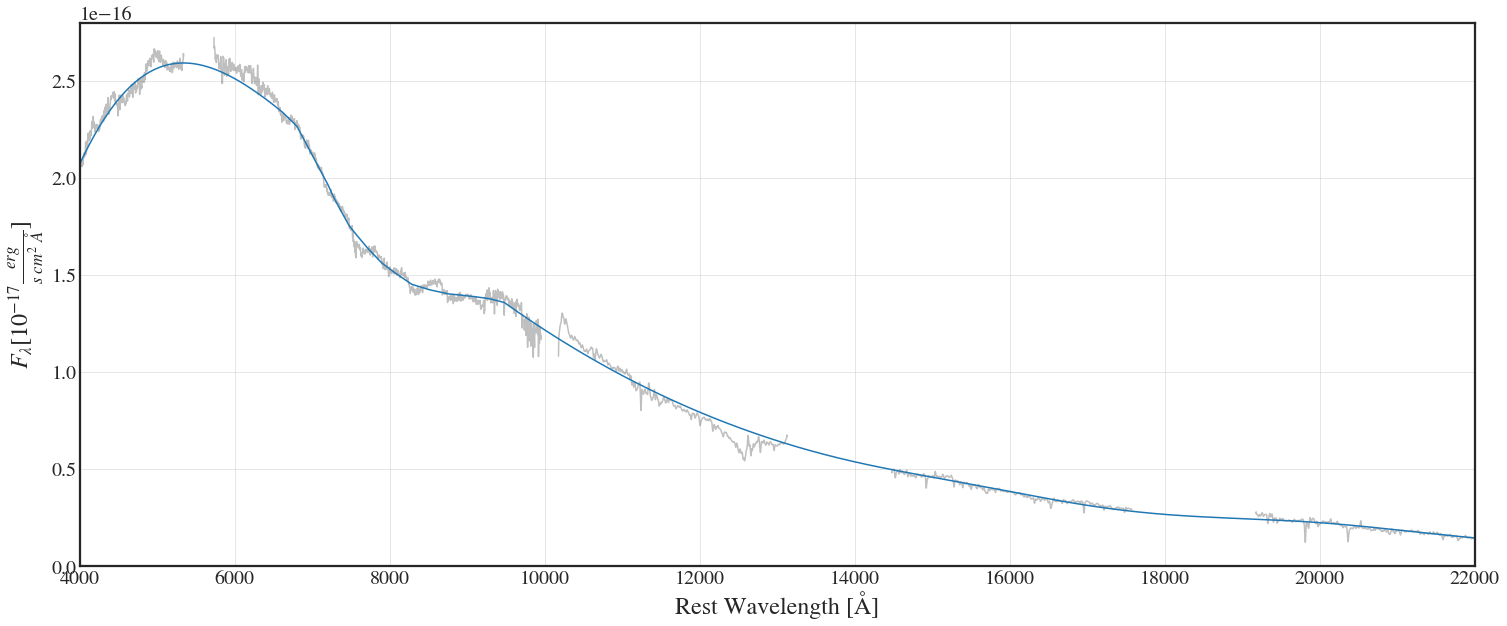

In [22]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [0]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
plt.xlim(4000, 22000)
plt.ylim(0, 2.8e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/first_epoch.png', dpi=300)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


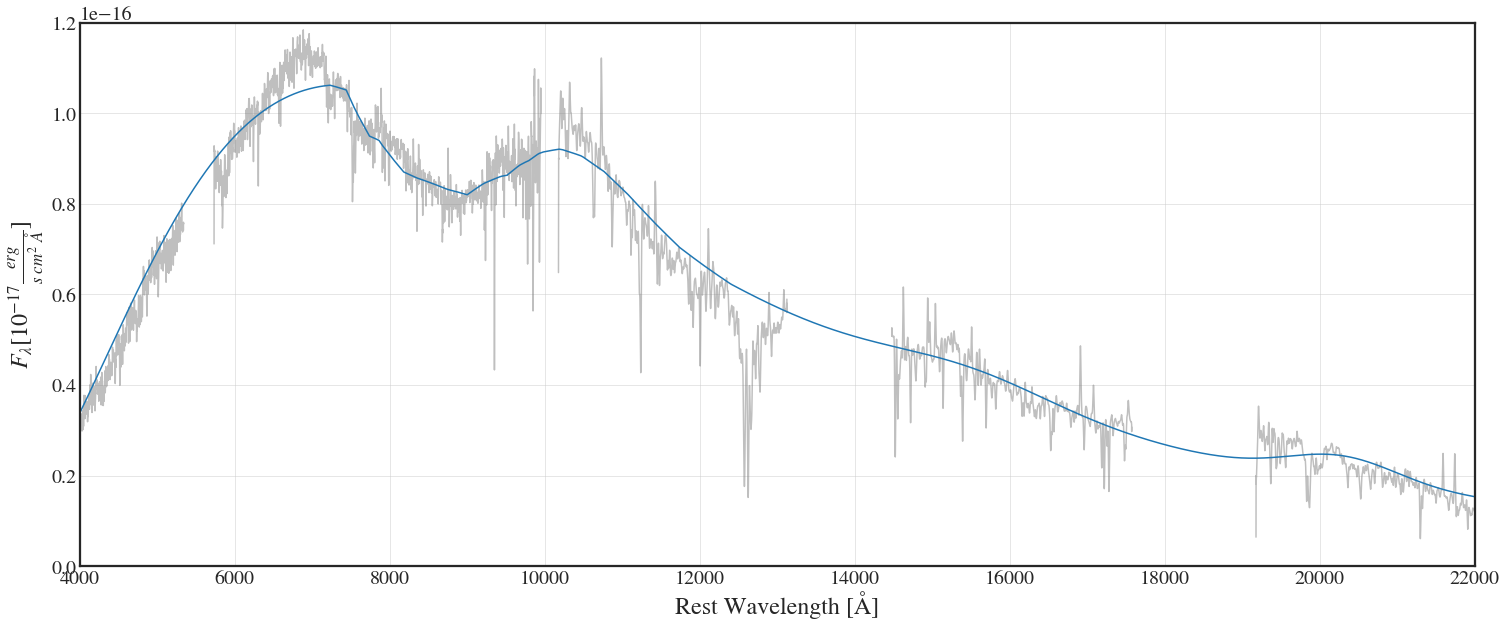

In [23]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [1]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
plt.xlim(4000, 22000)
plt.ylim(0, 1.2e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/first_epoch.png', dpi=300)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


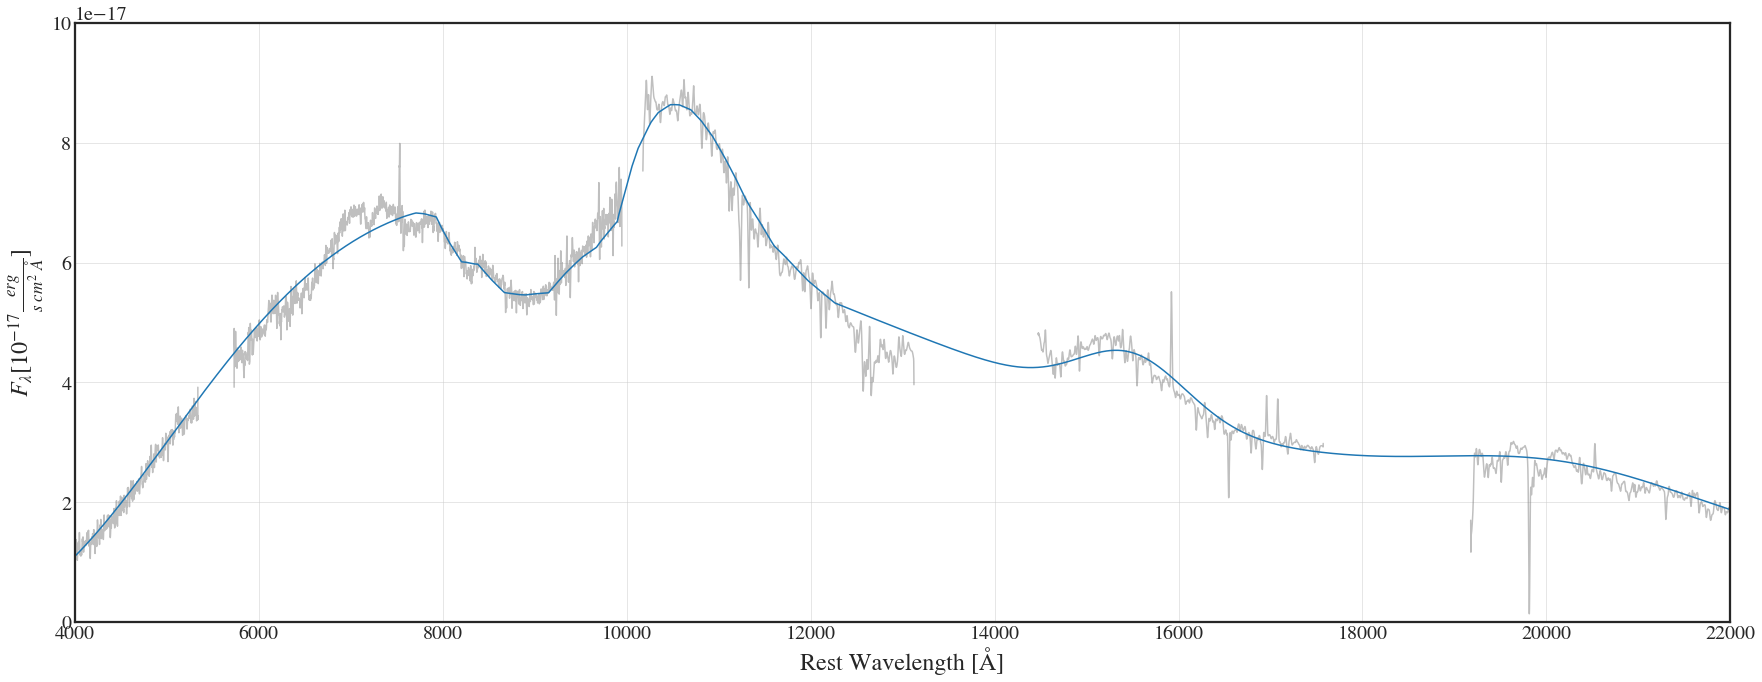

In [69]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [2]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
plt.xlim(4000, 22000)
plt.ylim(0, 1e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
plt.tight_layout()
plt.savefig('Pictures/3.png', dpi=300)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


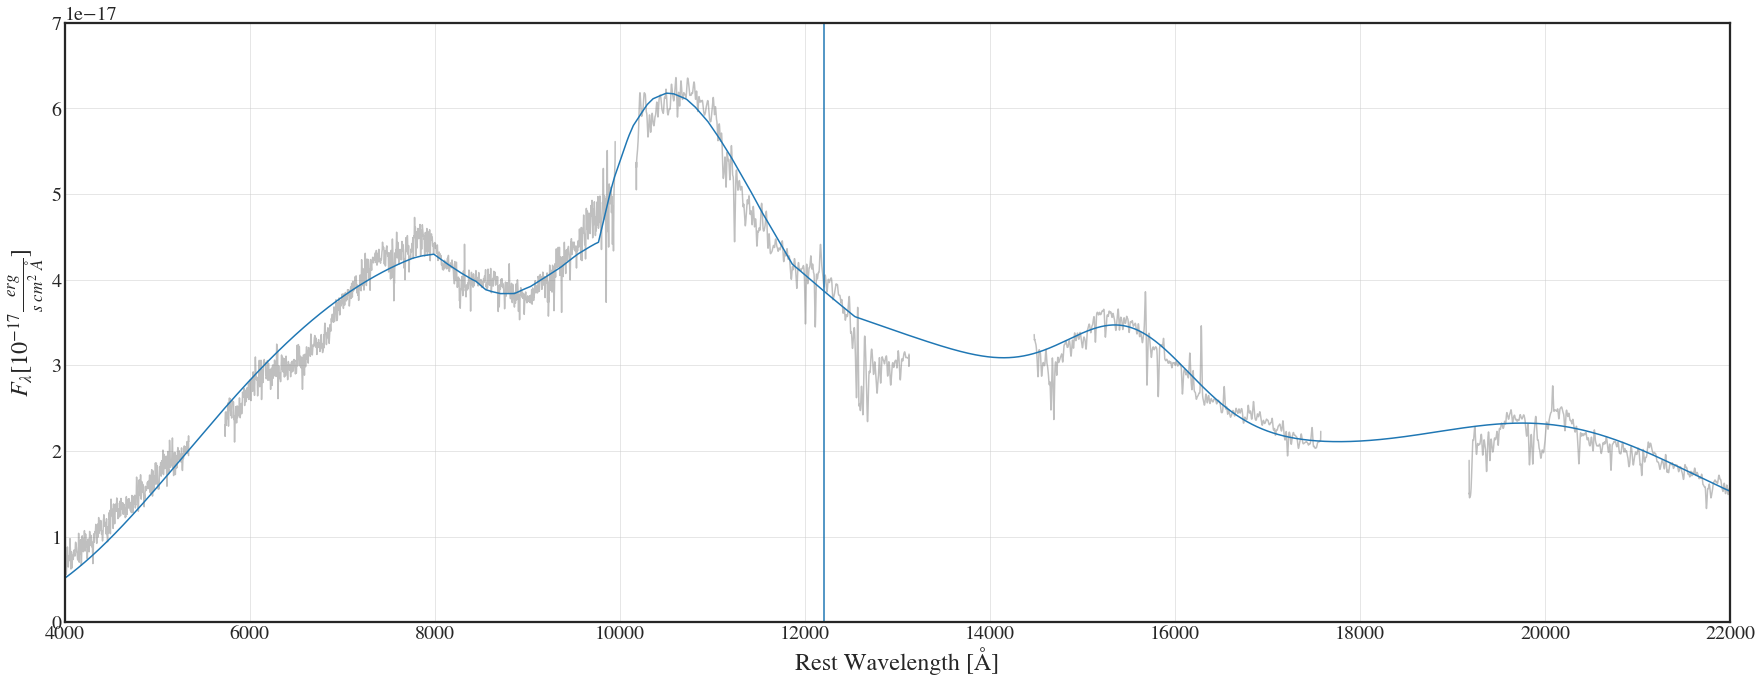

In [80]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [3]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
plt.xlim(4000, 22000)
plt.ylim(0, 0.7e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

plt.axvline(12200)
#plt.axvline(15250, ls='--')
plt.tight_layout()
#plt.savefig('Pictures/4.png', dpi=300)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]
C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval a

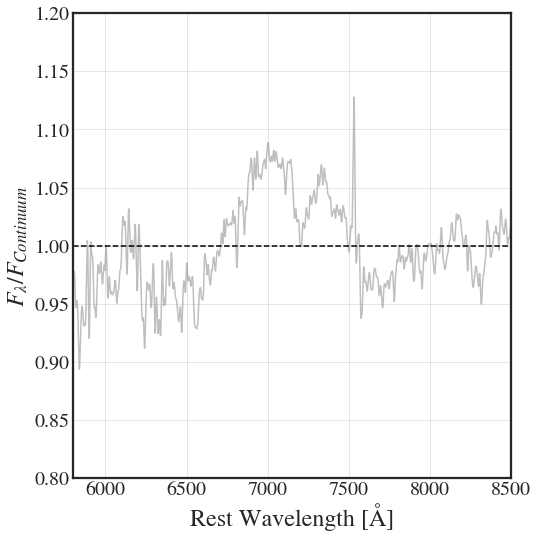

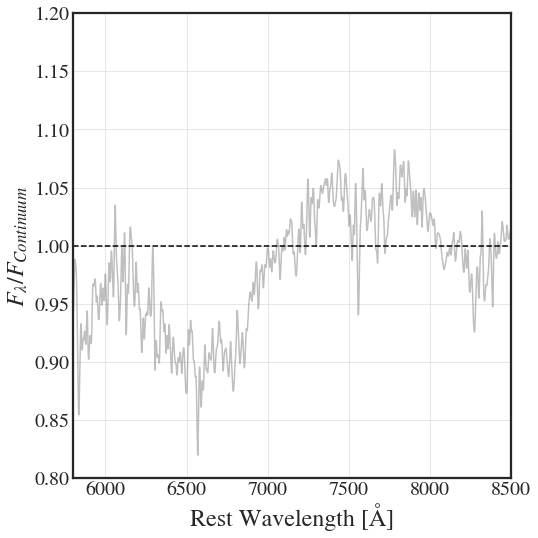

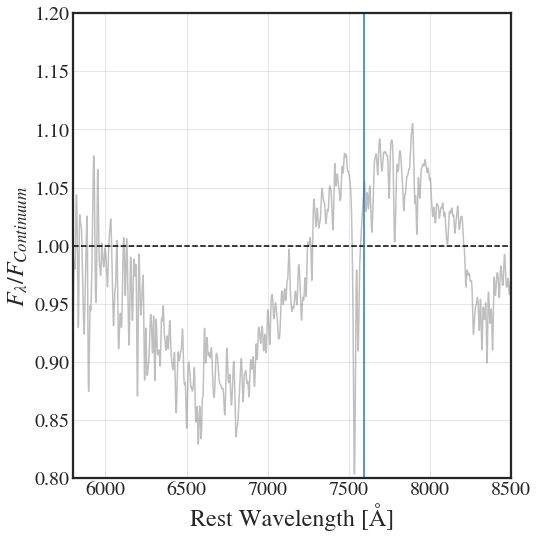

In [114]:
reset_plt(20, 24)
plt.figure(figsize=(8,8))

for i in [2]: 
    g = Gaussian1DKernel(stddev=20)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan)/flux_fit, #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5, label=3)
    #plt.plot(wl2, flux_fit)
plt.xlim(5800, 8500); plt.ylim(0.8, 1.2)    
plt.xlabel('Rest Wavelength [Å]'); plt.ylabel(r'$F_\lambda/F_{Continuum}  $')
plt.ticklabel_format(axis='x', style='plain')
plt.axhline(1, ls='--', color='k'); plt.tight_layout()
plt.savefig('Pictures/3_newline.png', dpi=300)


plt.figure(figsize=(8,8))
for i in [3]: 
    g = Gaussian1DKernel(stddev=20)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan)/flux_fit, #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5, label=4)
    #plt.plot(wl2, flux_fit)
plt.xlim(5800, 8500)
plt.ylim(0.8, 1.2)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda/F_{Continuum}  $')
plt.ticklabel_format(axis='x', style='plain')

plt.tight_layout(); plt.axhline(1, ls='--', color='k')
plt.savefig('Pictures/4_newline.png', dpi=300)

plt.figure(figsize=(8,8))
for i in [4]: 
    g = Gaussian1DKernel(stddev=20)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan)/flux_fit, #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5, label=4)
    #plt.plot(wl2, flux_fit)
plt.xlim(5800, 8500)
plt.ylim(0.8, 1.2)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda/F_{Continuum}  $')
plt.ticklabel_format(axis='x', style='plain')
plt.axhline(1, ls='--', color='k')
plt.axvline(12200); plt.tight_layout()
plt.axvline(7593)

plt.savefig('Pictures/5_newline.png', dpi=300)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]
C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


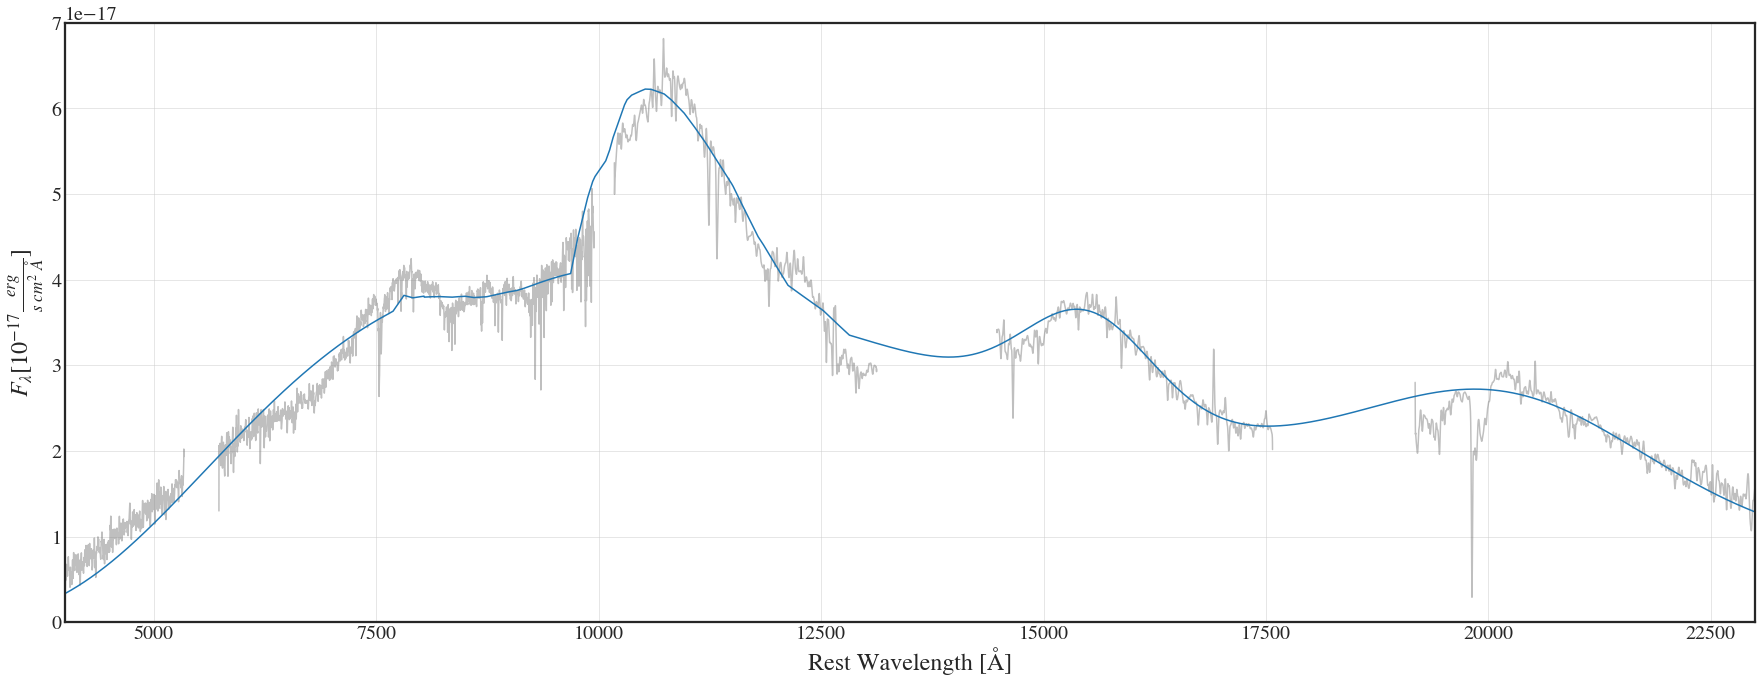

In [71]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=10)

    x = np.loadtxt(path+'/'+files[i]).T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    flux_fit = residual(emcee_res.params, wl2*1e-10)

#plt.ylim(-0.8, 0.8)
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    plt.plot(wl2, flux_fit)
plt.xlim(4000, 23000)
plt.ylim(0, 0.7e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
plt.tight_layout()
plt.savefig('Pictures/5.png', dpi=300)

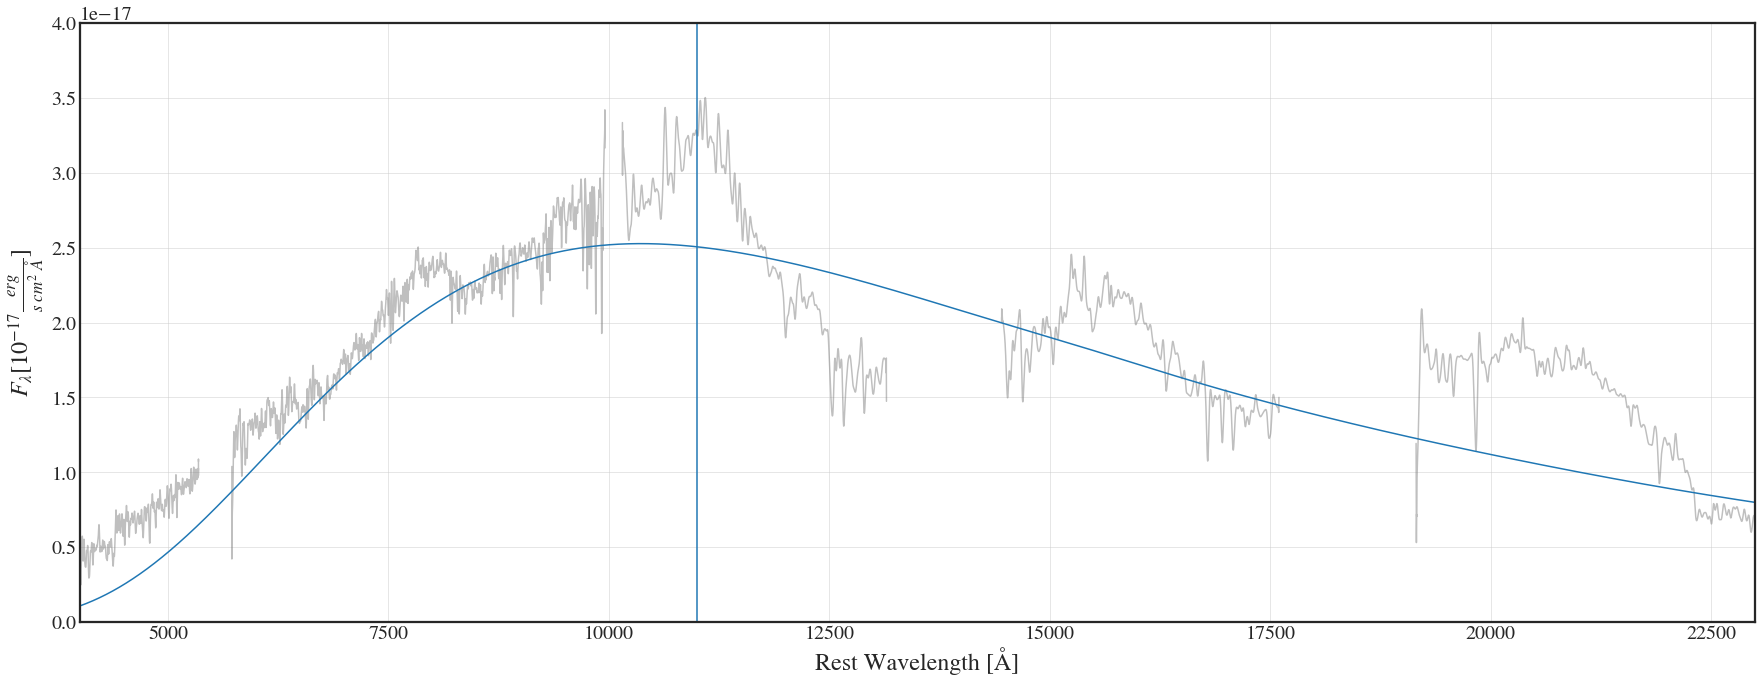

In [115]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=20)

    x = np.loadtxt('epoch6.txt').T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  
    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)
    
    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    
    emcee_res.params['T'].value = 2800
    emcee_res.params['N'].value = 3.6e-29
    emcee_res.params['amp1'].value = 0
    emcee_res.params['amp2'].value = 0
    emcee_res.params['tau'].value = 0
    
    flux_fit = residual(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit)
    
plt.xlim(4000, 23000)
plt.ylim(0, 0.4e-16)    
plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

plt.axvline(11000)
#plt.axvline(15250, ls='--')
plt.tight_layout()
#plt.savefig('Pictures/6.png', dpi=300)

name,value,standard error,relative error,initial value,min,max,vary
T,3057.21648,10.7511985,(0.35%),3082.0126789126225,2500.00000,7500.00000,True
N,3.7415e-29,7.8563e-31,(2.10%),3.555489174364442e-29,-inf,inf,True
vphot,0.14875107,2.7638e-04,(0.19%),0.1463207210618687,0.00000000,1.00000000,True
vmax,0.22292413,4.1400e-04,(0.19%),0.21928135867220525,0.00000000,1.00000000,True
t0,471600.000,,(0.19%),471600,-inf,inf,False
tau,0.18190151,0.00335820,(1.85%),0.1834959983955168,0.00000000,10.0000000,True
vref,0.00000000,,(1.85%),0.0,0.00000000,1.00000000,False
ve,0.29501626,0.01044844,(3.54%),0.312461843260899,0.00000000,1.00000000,True
occult,19.8850192,0.23832658,(1.20%),19.977395979360264,0.10000000,20.0000000,True
amp1,1.11723313,0.05580022,(4.99%),1.054442533548637,0.01000000,5.00000000,True


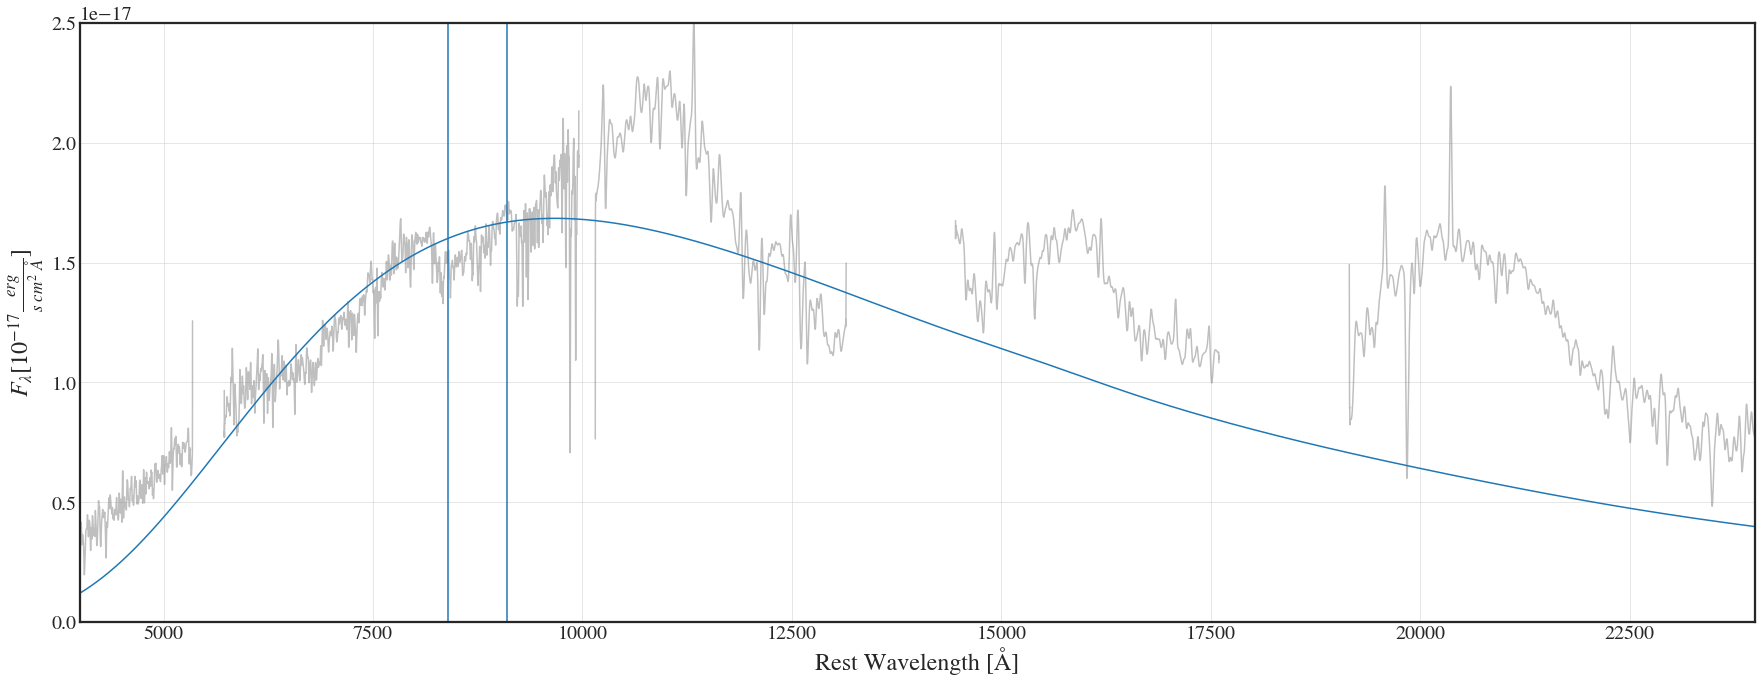

In [117]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=20)

    x = np.loadtxt('epoch7.txt').T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan
  


    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), #[(ratio < ratio_lim) & (ratio>-ratio_lim)], 
                 #fac*(convolve(flux2, g, fill_value=np.nan)-flux_fit), 
                color='grey', alpha=0.5)

    pickle_in = open(fit_res[i],"rb")
    emcee_res = pickle.load(pickle_in)
    
    emcee_res.params['T'].value = 3000
    emcee_res.params['N'].value = 1.7e-29
    emcee_res.params['amp1'].value = 0
    emcee_res.params['amp2'].value = 0
    emcee_res.params['tau'].value = 0

    flux_fit = residual(emcee_res.params, wl2*1e-10)
    plt.plot(wl2, flux_fit)    
    
plt.xlim(4000, 24000); plt.ylim(0, 0.25e-16); plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

plt.axvline(8400)

plt.axvline(9100)
#plt.axvline(15250, ls='--')
plt.tight_layout()
#plt.savefig('Pictures/7.png', dpi=300)

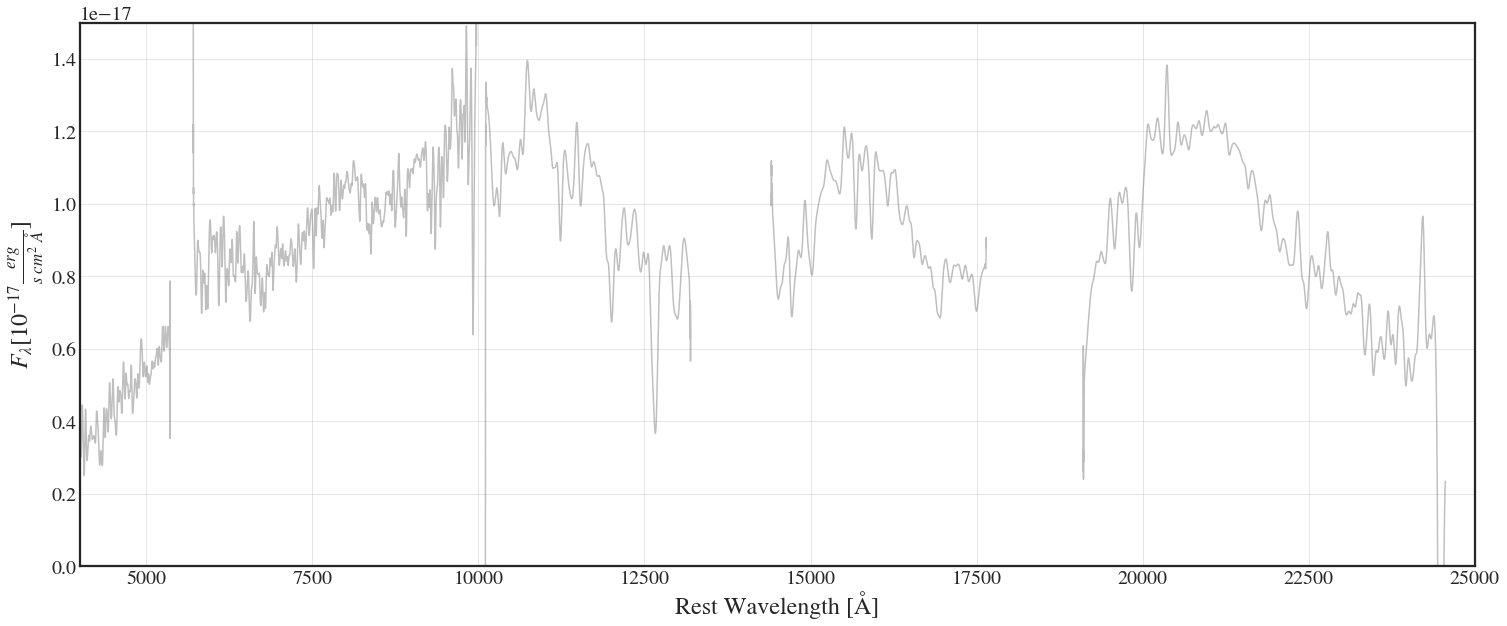

In [60]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=40)

    x = np.loadtxt('epoch8.txt').T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan

    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), 
                color='grey', alpha=0.5)

plt.xlim(4000, 25000); plt.ylim(0, 0.15e-16); plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/8.png', dpi=300)

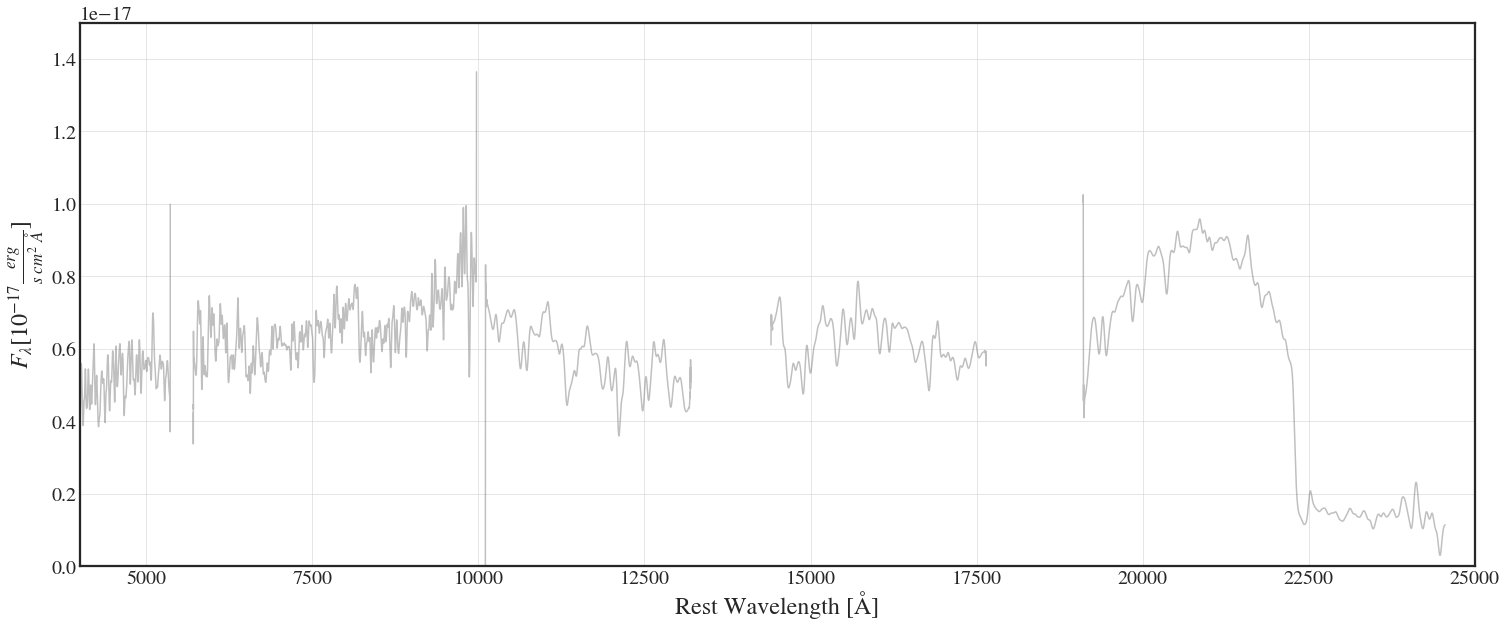

In [91]:
reset_plt(20, 24)
plt.figure(figsize=(25,10))

for i in [4]: 
    g = Gaussian1DKernel(stddev=40)

    x = np.loadtxt('epoch9.txt').T
    wl2, flux2, error2 = x[:,0], x[:,1], x[:,2]
    wl = wl2
    mask = ((wl > 3000) & (wl < 3600)) | ((wl > 5330) & (wl < 5740)) | ((wl > 9940) & (wl < 10200)) | ((wl > 13100) & (wl < 14400)) | ((wl > 13300) & (wl < 14500)) | ((wl > 17550) & (wl < 19200))
    flux2[mask] = np.nan; error2[mask] = np.nan

    plt.plot(wl2, convolve(flux2, g, fill_value=np.nan), 
                color='grey', alpha=0.5)

plt.xlim(4000, 25000); plt.ylim(0, 0.15e-16); plt.xlabel('Rest Wavelength [Å]'), 
plt.ylabel(r'$F_\lambda  [10^{-17} \frac{erg}{s \ cm^2 \ Å} ] $')
plt.ticklabel_format(axis='x', style='plain')

#plt.axvline(15500)
#plt.axvline(15250, ls='--')
#plt.savefig('Pictures/8.png', dpi=300)